# ITMAL Slutprojekt kode

**Created by Christopher Bernold for ITMAL class Fall 2019**

_References and links to inspiration:_


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import itertools
from pandas.plotting import scatter_matrix
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print(device_lib.list_local_devices())


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18424163402080563588
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6620742943
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15778577658333118130
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [4]:
print('Training set: X=%s, y=%s'%(x_train.shape,y_train.shape))
print('Test set: X=%s, y=%s'%(x_test.shape,y_test.shape))

Training set: X=(60000, 28, 28), y=(60000,)
Test set: X=(10000, 28, 28), y=(10000,)


Each image in the dataset is is associated with a single label from 0-9, to give a more clear view of what each item is instead of just a number, an array is created with each class name. 

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

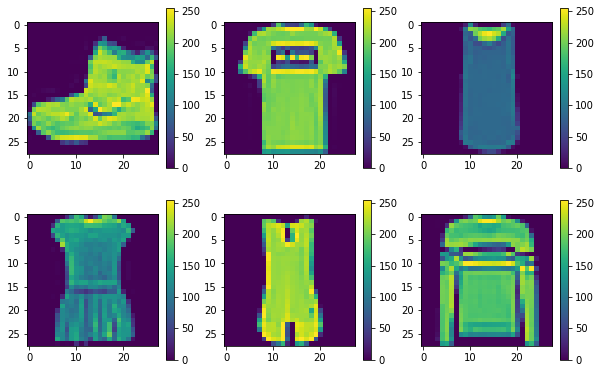

In [6]:
#First 6 images in the training dataset
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i])
    plt.colorbar()
    plt.grid(False)
plt.show()

Each image in the dataset is is associated with a single label from 0-9, to give a more clear view of what each item is instead of just a number, an array is created with each class name. 

In [7]:
#Normalizing input pixel values from 0-255 to 0-1

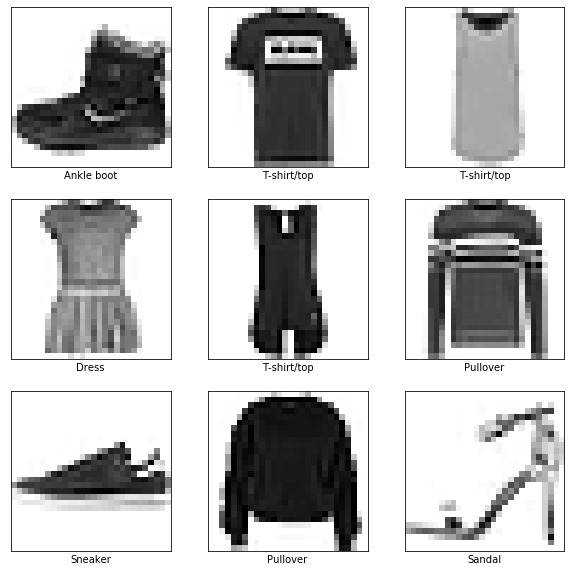

In [8]:
x_train = x_train/255
x_test = x_test/255

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
    plt.grid(False)
plt.show()


In [9]:
#Have to reshape the input data to get the correct input shape for the first layer in the convolution 
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

#The newly shaped data:
print('Training set: X=%s, y=%s'%(x_train.shape,y_train.shape))
print('Test set: X=%s, y=%s'%(x_test.shape,y_test.shape))


#One-hot encoding the labels.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

Training set: X=(60000, 28, 28, 1), y=(60000,)
Test set: X=(10000, 28, 28, 1), y=(10000,)


_One-hot encoding code inspired by journal_ : https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=1ShU787gZZg0 

In [10]:
#Initializing the model object
model = Sequential()
width, height = 28,28

#Convolutional layer
model.add(Conv2D(10,
                 kernel_size=3,
                 activation='relu',
                 input_shape=(width,height,1),
                 padding='same'))
model.add(AveragePooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(AveragePooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 20)        1820      
_________________________________________________________________
average_pooling2d_2 (Average (None, 7, 7, 20)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 20)          0         
______________________

In [11]:
tensorboard = TensorBoard(
    log_dir = r'logs\{}'.format('cnn'),
    write_graph=True,
    write_grads=True,
    histogram_freq=1,
    write_images = True,
)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
trained_model = model.fit(x_train,y_train,
                          validation_split=0.2,
                          epochs=20,
                          batch_size=10,
                          callbacks=[tensorboard])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 48000 samples, validate on 12000 samples




Epoch 1/20
48000/48000 [==============================] - 21s 437us/step - loss: 0.5650 - acc: 0.7878 - val_loss: 0.4095 - val_acc: 0.8489
Epoch 2/20
48000/48000 [==============================] - 19s 391us/step - loss: 0.4064 - acc: 0.8491 - val_loss: 0.3438 - val_acc: 0.8697
Epoch 3/20
48000/48000 [==============================] - 18s 379us/step - loss: 0.3676 - acc: 0.8620 - val_loss: 0.3151 - val_acc: 0.8827
Epoch 4/20
48000/48000 [==============================] - 18s 375us/step - loss: 0.3406 - acc: 0.8715 - val_loss: 0.3194 - val_acc: 0.8805
Epoch 5/20
48000/48000 [==============================] - 19s 390us/step - loss: 0.3237 - acc: 0.8780 - val_loss: 0.2827 - val_acc: 0.8945
Epoch 6/20
48000/48000 [==============================] - 19s 391us/step - loss: 0.3124 - acc: 0.8834 - val_loss: 0.2878 - val_acc: 0.8942
Epoch 7/20
48000/4

In [20]:
score = model.evaluate(x_test, y_test, verbose= 0)

print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2613
Test Accuracy : 0.9026


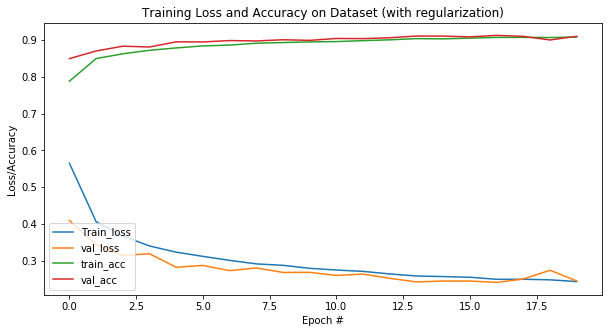

In [14]:
#test set prediction
prediction = model.predict(x_test)

num_of_epochs = 20

plt.figure(figsize=(10,5))
plt.plot(np.arange(0, num_of_epochs), trained_model.history["loss"], label ="Train_loss")
plt.plot(np.arange(0, num_of_epochs), trained_model.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_of_epochs), trained_model.history["acc"], label="train_acc")
plt.plot(np.arange(0, num_of_epochs), trained_model.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset (with regularization)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

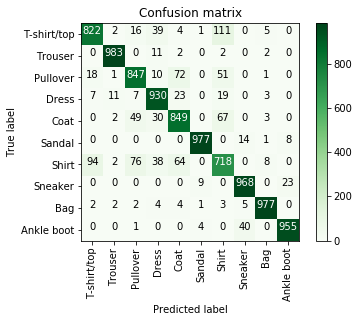

In [15]:
#Confusion matrix plotting inspired by: https://www.kaggle.com/fuzzywizard/fashion-mnist-cnn-keras-accuracy-93
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.ylim(cm.shape[0] - 0.5, -0.5)
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Converting prediction classes to one hot vectors
Y_prediction_classes = np.argmax(prediction, 1)

#True labels as one-hot vector
Y_true = np.argmax(y_test, 1)

confusion_matrix_classes = confusion_matrix(Y_true, Y_prediction_classes)

plot_confusion_matrix(confusion_matrix_classes, classes = class_names)

In [16]:
print(classification_report(Y_true, Y_prediction_classes, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.82      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.85      0.85      0.85      1000
       Dress       0.88      0.93      0.90      1000
        Coat       0.83      0.85      0.84      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.74      0.72      0.73      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



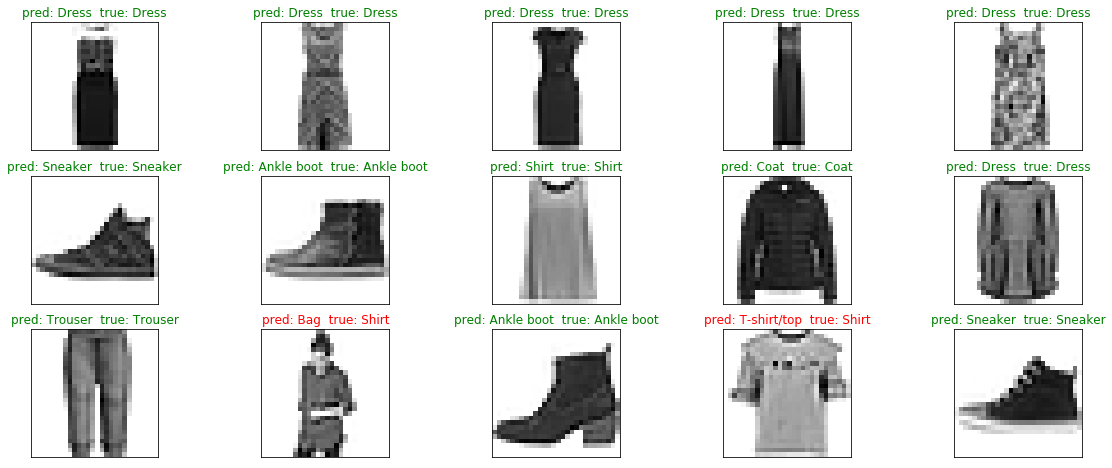

In [23]:
figure = plt.figure(figsize=(20,8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    random_image=figure.add_subplot(3,5,i+1,xticks=[],yticks=[])
    random_image.imshow(np.squeeze(x_test[index]), cmap=plt.cm.binary)
    predict_index = np.argmax(prediction[index])
    true_index =np.argmax(y_test[index])
    random_image.set_title("pred: {}  true: {}".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [18]:
#Initializing the model object
model_no_regulariazation = Sequential()
width, height = 28,28

#Convolutional layer
model_no_regulariazation.add(Conv2D(10,
                 kernel_size=3,
                 activation='relu',
                 input_shape=(width,height,1),
                 padding='same'))
model_no_regulariazation.add(AveragePooling2D())

model_no_regulariazation.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
model_no_regulariazation.add(AveragePooling2D())


model_no_regulariazation.add(Conv2D(20,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

model_no_regulariazation.add(Flatten())
model_no_regulariazation.add(Dense(100, activation='relu'))
model_no_regulariazation.add(Dense(10, activation='softmax'))
model_no_regulariazation.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
average_pooling2d_3 (Average (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 20)        1820      
_________________________________________________________________
average_pooling2d_4 (Average (None, 7, 7, 20)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 20)          3620      
_________________________________________________________________
flatten_2 (Flatten)          (None, 980)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               98100     
__________

In [26]:
model_no_regulariazation.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

trained_model_no_reg = model_no_regulariazation.fit(x_train,y_train,
                          validation_split=0.2,
                          epochs=20,
                          batch_size=10)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 18s 383us/step - loss: 0.2754 - acc: 0.8982 - val_loss: 0.2856 - val_acc: 0.8939
Epoch 2/20
48000/48000 [==============================] - 18s 369us/step - loss: 0.2440 - acc: 0.9093 - val_loss: 0.2750 - val_acc: 0.8992
Epoch 3/20
48000/48000 [==============================] - 17s 363us/step - loss: 0.2178 - acc: 0.9192 - val_loss: 0.2619 - val_acc: 0.9009
Epoch 4/20
48000/48000 [==============================] - 17s 359us/step - loss: 0.1995 - acc: 0.9250 - val_loss: 0.2606 - val_acc: 0.9054
Epoch 5/20
48000/48000 [==============================] - 18s 368us/step - loss: 0.1825 - acc: 0.9315 - val_loss: 0.2486 - val_acc: 0.9113
Epoch 6/20
48000/48000 [==============================] - 17s 363us/step - loss: 0.1685 - acc: 0.9372 - val_loss: 0.2487 - val_acc: 0.9147
Epoch 7/20
48000/48000 [==============================] - 18s 376us/step - loss: 0.1526 - acc: 0.9427 - val_loss: 0.

In [27]:
no_reg_score = model_no_regulariazation.evaluate(x_test, y_test, verbose= 0)

print('Test Loss : {:.4f}'.format(no_reg_score[0]))
print('Test Accuracy : {:.4f}'.format(no_reg_score[1]))

Test Loss : 0.4623
Test Accuracy : 0.9081


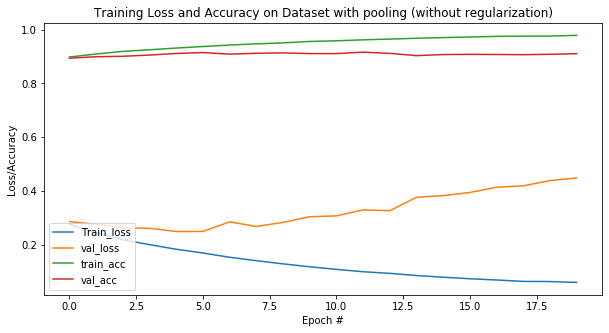

In [28]:
#plotting a model with no regularization or pooling added. 
prediction_no_reg = model_no_regulariazation.predict(x_test)

num_of_epochs = 20

plt.figure(figsize=(10,5))
plt.plot(np.arange(0, num_of_epochs), trained_model_no_reg.history["loss"], label ="Train_loss")
plt.plot(np.arange(0, num_of_epochs), trained_model_no_reg.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_of_epochs), trained_model_no_reg.history["acc"], label="train_acc")
plt.plot(np.arange(0, num_of_epochs), trained_model_no_reg.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset with pooling (without regularization)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()